<a href="https://colab.research.google.com/github/charliewigul/Music-Genre-Classification/blob/main/music_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import string
from re import S
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

<font size = 12> Lyric-Based Classification

<font size = 6> Load Dataset

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# loading test and train
## NOT WORKING FOR JOSH
test_df = pd.read_csv('/content/drive/MyDrive/Data 144- Final/Lyrics dataset/test.csv')
train_df = pd.read_csv('/content/drive/MyDrive/Data 144- Final/Lyrics dataset/train.csv')

In [ ]:
# filtering datasets
test_df = test_df[['Genre', 'Lyrics', 'Track_id']]
train_df = train_df[['Genre', 'Lyrics']].dropna()

In [ ]:
# display datasets
train_df

,Genre,Lyrics
0,Rock,"It starts with pain, followed by hate\nFueled ..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...
2,Rock,"Biting the hand that feeds you, lying to the v..."
3,Rock,You say you know just who I am\nBut you can't ...
4,Rock,My heart is beating faster can't control these...
...,...,...
290178,R&B,I'm the best friend he's got I'd give him the ...
290179,Pop,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
290180,Pop,Forgive me for the things That I never said to...
290181,Indie,The day they found a cure for AIDS The day the...


<font size = 6> Data Cleaning

In [ ]:
# clean lyrics before splitting
## takes around
def clean_data(df, size=False):

  # downsize dataset
  if size:
    df = df.sample(size)

  # replace newlines with spaces
  df['Lyrics'] = df['Lyrics'].str.replace('\n', ' ')

  # remove punctuation
  translator = str.maketrans('', '', string.punctuation)
  df['Lyrics'] = df['Lyrics'].str.translate(translator)

  # lowercase
  df['Lyrics'] = df['Lyrics'].str.lower()

  # remove numbers
  df['Lyrics'] = df['Lyrics'].str.replace(r'\b\w*\d\w*\b', '', regex=True)

  # # remove songs that are not in English
  # def detect_language(text):
  #       try:
  #           return detect(text)
  #       except LangDetectException:
  #           return 'unknown'

  # df['language'] = df['Lyrics'].apply(detect_language)
  # df = df[df['language'] == 'en'].drop(columns=['language'])

  return df

In [ ]:
# show
cleaned_train = clean_data(train_df, size=5000)
cleaned_train

,Genre,Lyrics
284791,Pop,look over yonder what do you see the sun is ar...
133305,Pop,pegueme aqueçame em seu corpo amor quero te am...
93438,Pop,santa tell me if youre really there dont make ...
65743,Pop,alalalalalways count on me we both know theres...
112503,Indie,seu sorriso pra mim viu é madeira seu sorriso ...
...,...,...
93815,Pop,yeahehheah you are my fire the one desire beli...
198989,Metal,that was solid chemistry that was there with y...
206780,Pop,im thinking it over the way you make me feel a...
2437,Rock,shut your mouth and listen closely because thi...


<font size = 6> Basic Feature Engineering

In [ ]:
# split into words
# arguments batch size and max features for memory

def create_word_count_df(df):
  vectorizer = CountVectorizer()
  word_count_matrix = vectorizer.fit_transform(df['Lyrics'])
  word_count_df = pd.DataFrame(word_count_matrix.toarray(), columns=vectorizer.get_feature_names_out())
  result_df = pd.concat([df[['Genre', 'Lyrics']].reset_index(drop=True), word_count_df], axis=1)
  return result_df


In [ ]:
# show
train_words = create_word_count_df(cleaned_train)
train_words

,Genre,Lyrics,aa,aaaaaaa,aaaaaaaaa,aaaaaaaagggghhhhhhh,aaaaaaaawwwww,aaaaaahhhhhhhhh,aaaah,aaah,...,única,único,útero,übel,über,þér,þín,þörfin,œuâœ,ṗretend
0,Pop,look over yonder what do you see the sun is ar...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Pop,pegueme aqueçame em seu corpo amor quero te am...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Pop,santa tell me if youre really there dont make ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Pop,alalalalalways count on me we both know theres...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Indie,seu sorriso pra mim viu é madeira seu sorriso ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Pop,yeahehheah you are my fire the one desire beli...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,Metal,that was solid chemistry that was there with y...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,Pop,im thinking it over the way you make me feel a...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,Rock,shut your mouth and listen closely because thi...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<font size = 6> Dimensionality Reduction/Visualization

- visualize clusters colored by genre based on word counts
- see if there is underlying distribution

In [ ]:
# dimensionality reduction

features = train_words.drop(['Genre', 'Lyrics'], axis=1)

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

tsne_df = pd.DataFrame(data=reduced_features, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Genre'] = train_words['Genre']

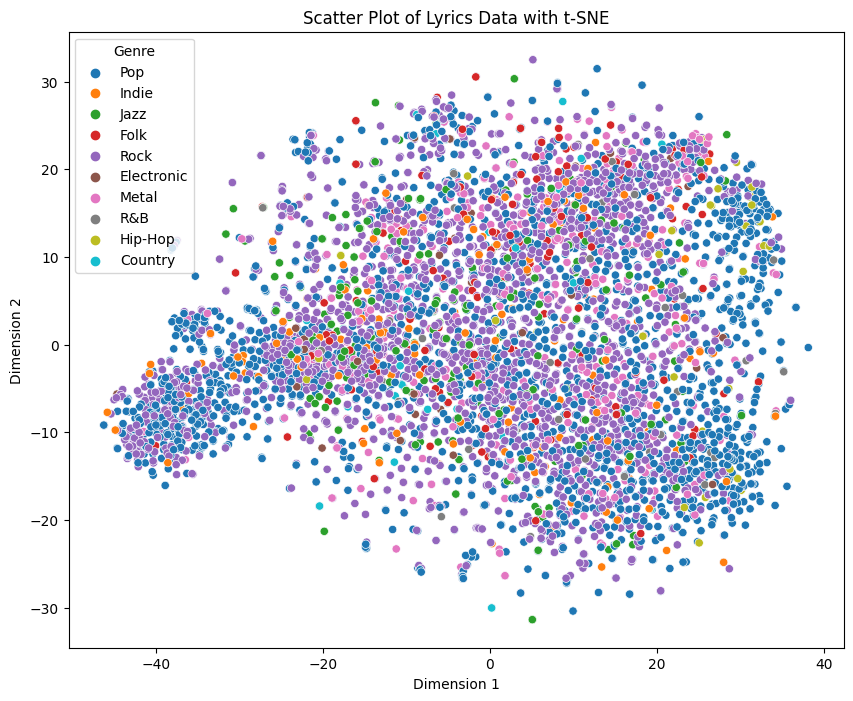

In [ ]:
# visualize
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Genre', data=tsne_df)
plt.title('Scatter Plot of Lyrics Data with t-SNE')
plt.show()

<font size = 12> Audio-Based Classification

<font size = 6> Load Dataset

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading datasets
three_sec = pd.read_csv('/content/drive/MyDrive/Data 144- Final/GTZAN dataset/features_3_sec.csv')
thirty_sec = pd.read_csv('/content/drive/MyDrive/Data 144- Final/GTZAN dataset/features_30_sec.csv')

In [ ]:
# show
thirty_sec

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


<font size = 6> Initial Visualization/Dimensionality Reduction

In [ ]:
# dimensionality reduction

features = thirty_sec.drop(['filename', 'label'], axis=1)

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

tsne_df = pd.DataFrame(data=reduced_features, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Genre'] = thirty_sec['label']

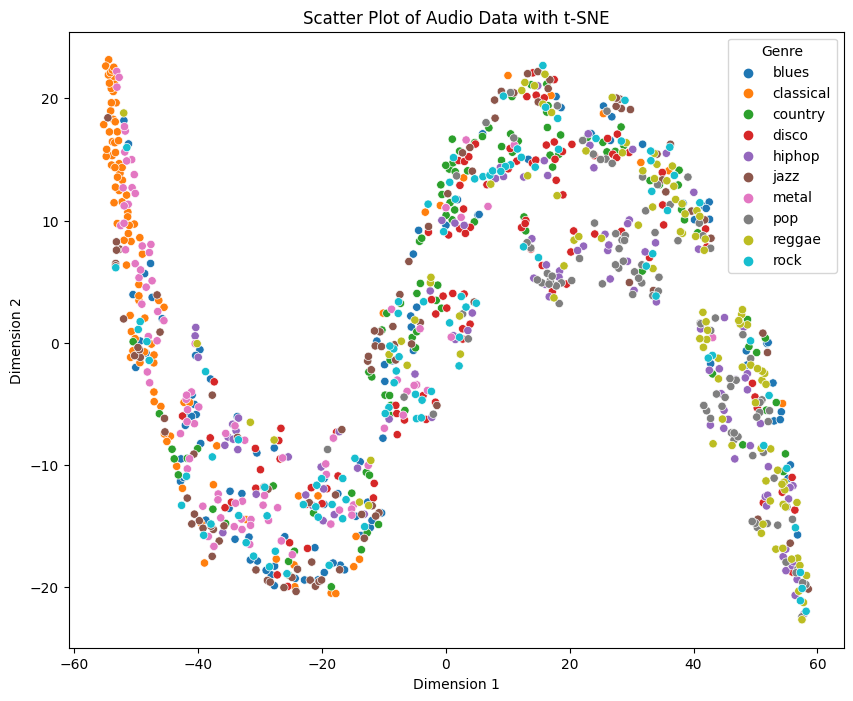

In [ ]:
# visualize
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Genre', data=tsne_df)
plt.title('Scatter Plot of Audio Data with t-SNE')
plt.show()

## THOUGHTS: use plotly to make interactive? or whatever package we used in lab

<font size = 12> Audio AND Lyric Based Classification

<font size = 6> Load/Clean Dataset

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load dataset
songs = pd.read_csv('/content/drive/MyDrive/Data 144- Final/Spotify music dataset/spotify_songs.csv')

In [ ]:
# clean dataset
songs = songs.rename(columns={'playlist_genre':'genre', 'playlist_subgenre':'subgenre'})
songs['lyrics'] = songs['lyrics'].fillna(value='')
songs['language'] = songs['language'].fillna(value='unknown')

In [ ]:
# show
songs

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,...,-10.068,1,0.0236,0.27900,0.011700,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,-4.739,1,0.0442,0.01170,0.009940,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,-7.504,0,0.2160,0.00432,0.007230,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,-5.819,0,0.0341,0.68900,0.000000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,-1.993,1,0.0409,0.03700,0.000000,0.1380,0.240,130.018,193160,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18449,7zXzWCVuz7whIuYZyEAlxt,Rising Like The Sun - Radio Mix,Qulinez,"Caught up in such a head rush, wide-eyed latel...",0,1l4aoukbPgi5u2OaE2R4Zj,Rising Like The Sun,2014-03-24,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,...,-5.778,0,0.0878,0.00555,0.000000,0.3350,0.211,128.012,208656,en
18450,7zycSpvjDcqh6YT1FEl2kY,Anaconda,Nicki Minaj,"My anaconda don't, my anaconda don't My anacon...",49,5qs8T6ZHSrnllnOuUk6muC,The Pinkprint (Deluxe Edition),2014-12-15,10er Playlist,1kEczIkZH8IgaWT2BiApxZ,...,-6.224,1,0.1800,0.06730,0.000006,0.2140,0.647,129.990,260240,en
18451,7zye9v6B785eFWEFYs13C2,Bound,Ponderosa Twins Plus One,"Bound, bound Bound, bound Bound to fall in lov...",40,1xdgLmTFMSyJyI5DJOOX7T,2+2+1 = (Digitally Remastered),2013-07-09,Sexy Soul 2020,5EMARioe9z9eKOeWIAC2JW,...,-6.457,0,0.0270,0.71500,0.000428,0.1150,0.657,142.218,191205,en
18452,7zyLObYw4QUKQDyZOb4J0Y,I'll Do 4 U (Re-Recorded / Remastered),Father MC,(Would you do for me) Sweetheart (Would you do...,36,14HYMxFhpgDIr9cci1u0kt,I'll Do 4 U (Re-Recorded / Remastered),2010-10-01,New Jack Swing/ R&B Hits: 1987 - 2002,4sji14lrB5bgcr51lPALYH,...,-4.920,0,0.0633,0.14300,0.000000,0.0720,0.810,109.536,223890,en


In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(songs, songs['genre'], random_state=42)

<font size = 6> Dataset Overview

In [ ]:
# genre counts
songs.groupby('genre').size()

genre
edm      2045
latin    2178
pop      3993
r&b      3326
rap      3391
rock     3521
dtype: int64

In [ ]:
# list of features
songs.columns

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'genre', 'subgenre', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'language'],
      dtype='object')

<font size = 6> EDA/Feature Engineering

Audio Features

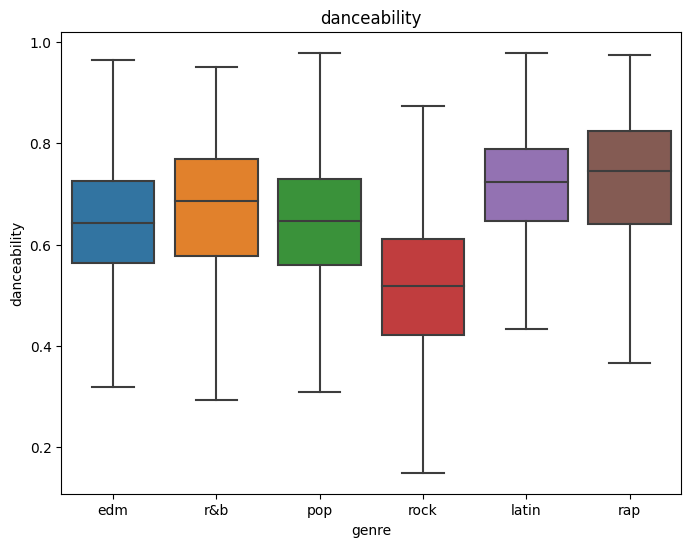

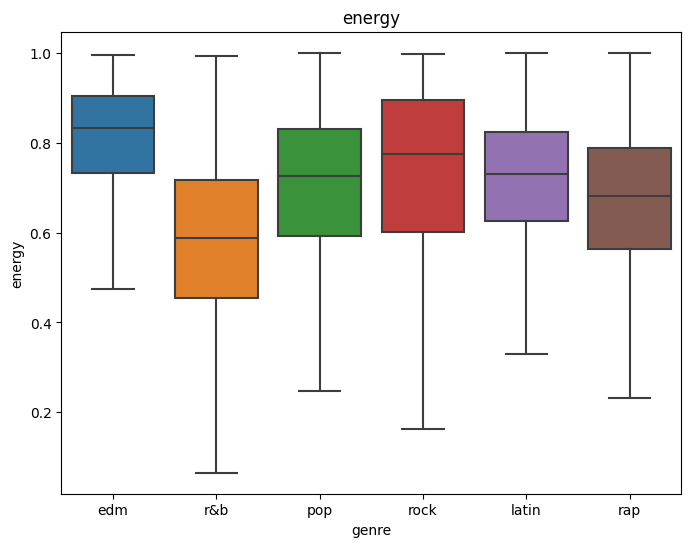

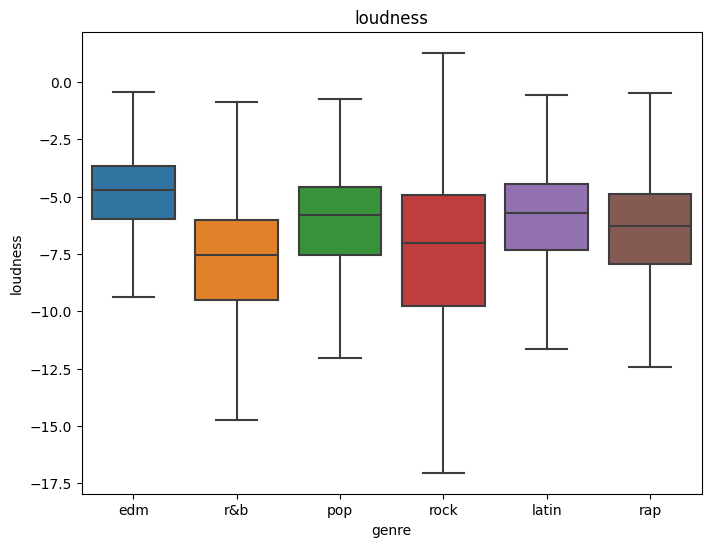

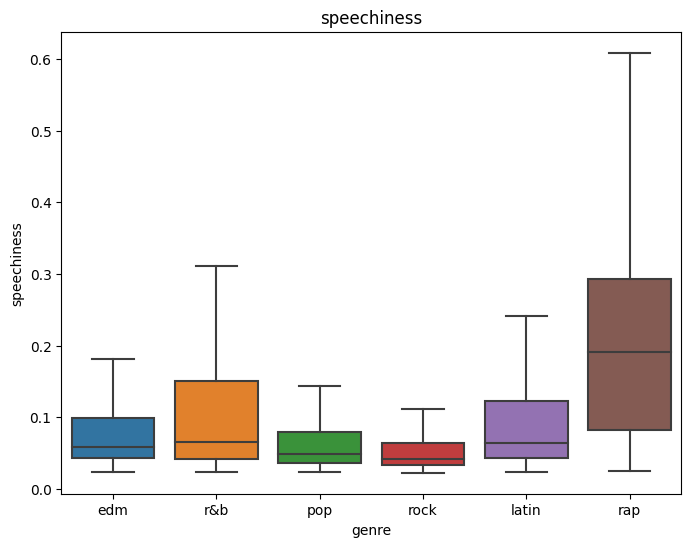

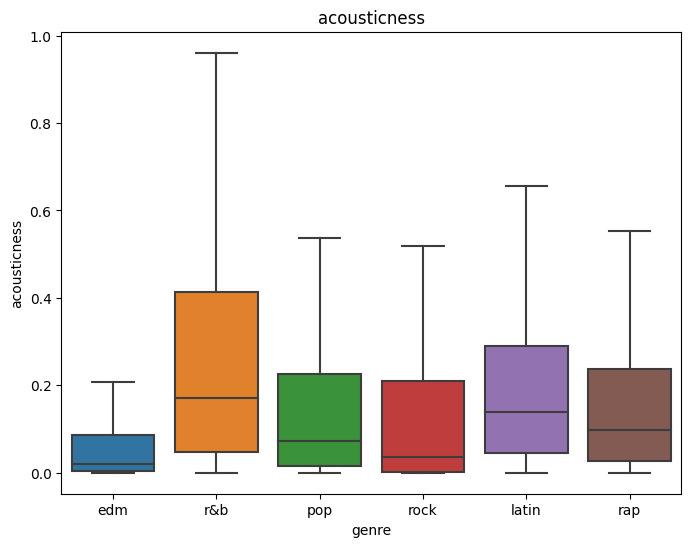

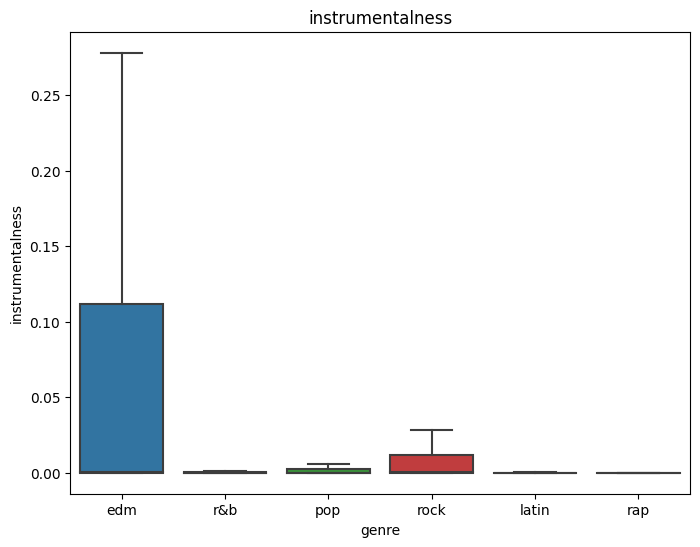

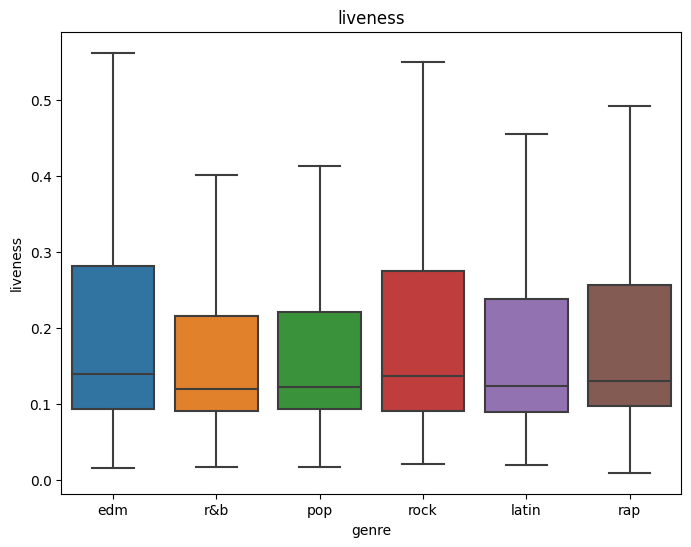

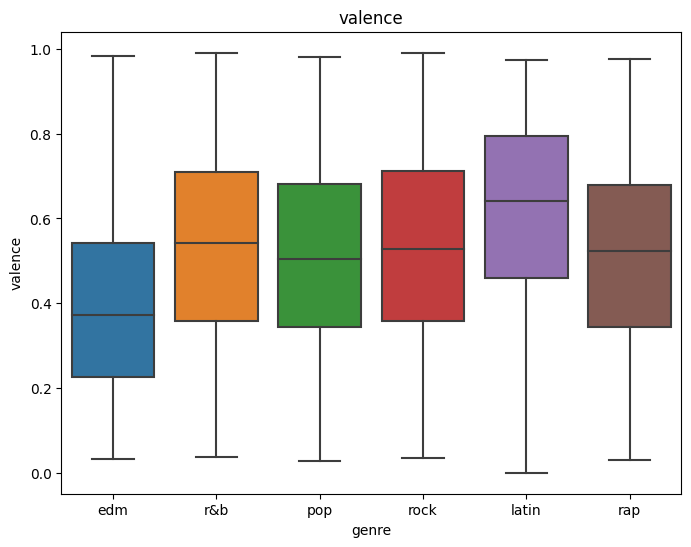

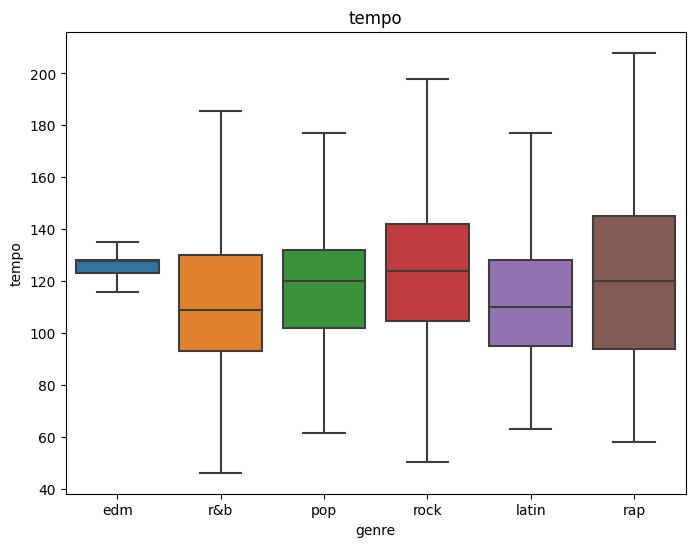

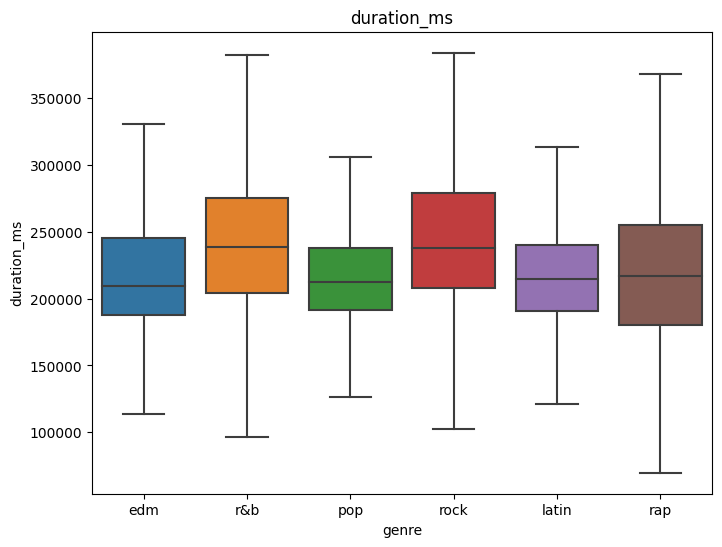

In [ ]:
# visualize numerical audio features
def visualize_numerical_audio_feature(feature):
  plt.figure(figsize=(8, 6))
  sns.boxplot(data=X_train, x='genre', y=feature, showfliers=False)
  plt.title(feature)

numerical_audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
for feature in numerical_audio_features:
  visualize_numerical_audio_feature(feature)

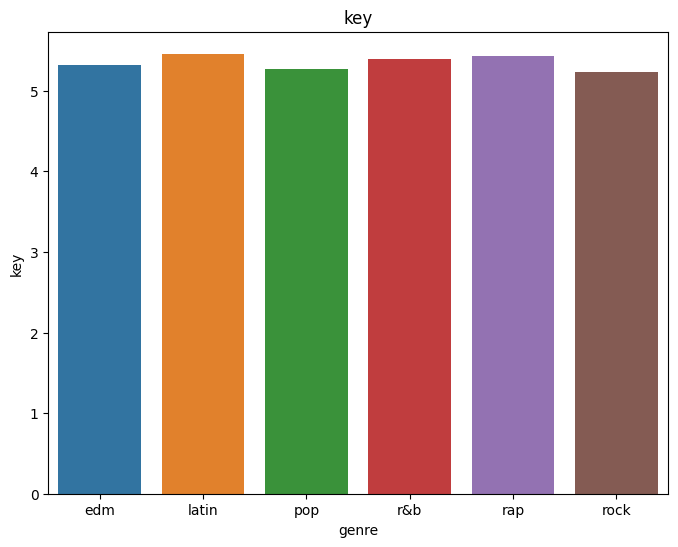

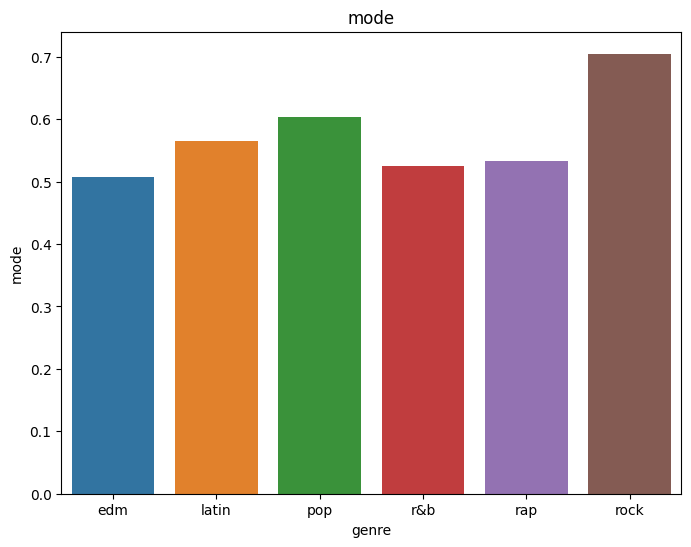

In [ ]:
# visualize categorical audio features
def visualize_categorical_audio_feature(feature):
  averages = songs.groupby('genre')[feature].mean()
  plt.figure(figsize=(8, 6))
  sns.barplot(x=averages.index, y=averages)
  plt.title(feature)

categorical_audio_features = ['key', 'mode']
for feature in categorical_audio_features:
  visualize_categorical_audio_feature(feature)

Lyric Features

In [ ]:
# extract lyric length
def make_lyric_length(df):
  df['lyrics_length'] = df['lyrics'].str.split().apply(len)

Text(0.5, 1.0, 'Lyric Length')

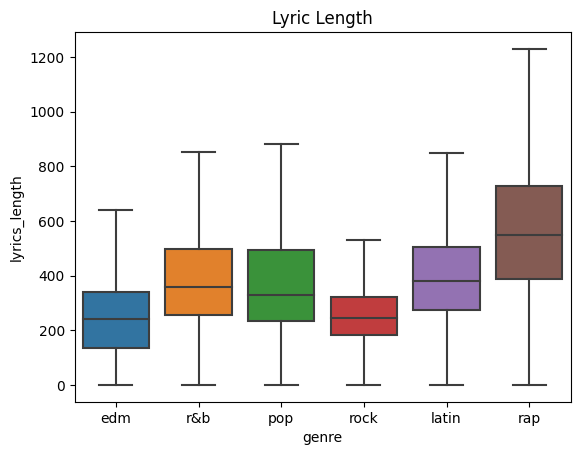

In [ ]:
# visualize lyrics length
make_lyric_length(X_train)
sns.boxplot(data=X_train, x='genre', y='lyrics_length', showfliers=False)
plt.title('Lyric Length')

In [ ]:
# extract word counts
def make_word_counts(df, words):
  for i in words:
    df[i] = df['lyrics'].str.count(i)

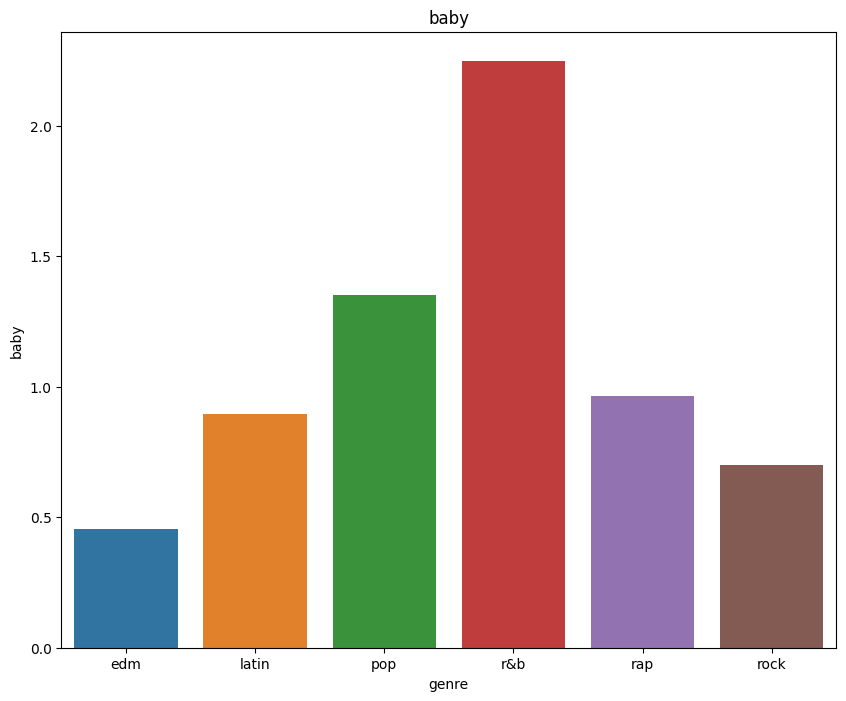

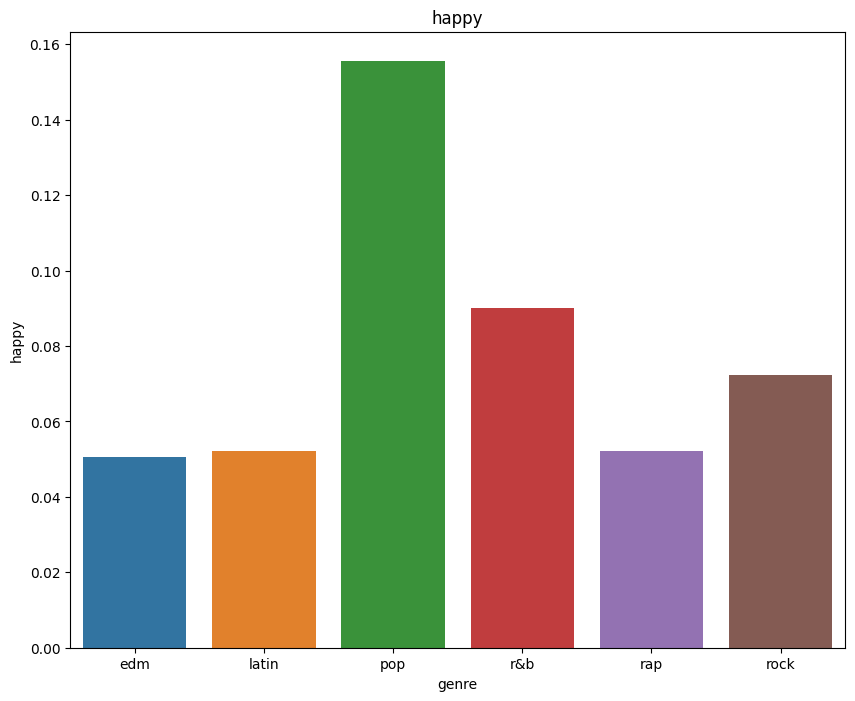

In [ ]:
# visualize word counts
word_list = ['baby', 'happy',]
make_word_counts(X_train, word_list)

for i in word_list:
  plt.figure(figsize=(10, 8))
  average_count = X_train.groupby('genre')[i].mean()
  sns.barplot(x=average_count.index, y=average_count)
  plt.title(i)

In [ ]:
# extract sentiment
from textblob import TextBlob

def make_sentiment(df):
  def analyze_sentiment(text):
      blob = TextBlob(text)
      polarity = blob.sentiment.polarity
      if polarity > 0:
          sentiment = 'positive'
      elif polarity == 0:
          sentiment = 'neutral'
      else:
          sentiment = 'negative'
      return polarity
  df['sentiment'] = songs['lyrics'].apply(analyze_sentiment)

Text(0.5, 1.0, 'Sentiment')

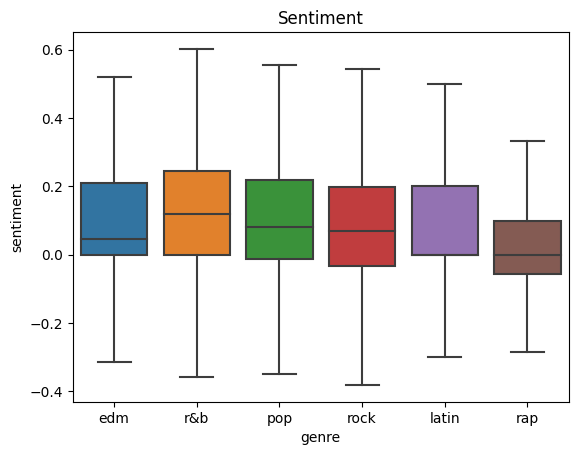

In [ ]:
# visualize sentiment
make_sentiment(X_train)
sns.boxplot(data=X_train, x='genre', y='sentiment', showfliers=False)
plt.title('Sentiment')

In [ ]:
#extract unique words
def make_unique(df):
  def count_unique_words(text):

      text_lower = text.lower()

      words = re.findall(r'\b\w+\b', text_lower)
      num_unique_words = len(set(words))

      return num_unique_words
  df['unique'] = df['lyrics'].apply(count_unique_words)

Text(0.5, 1.0, 'Unique')

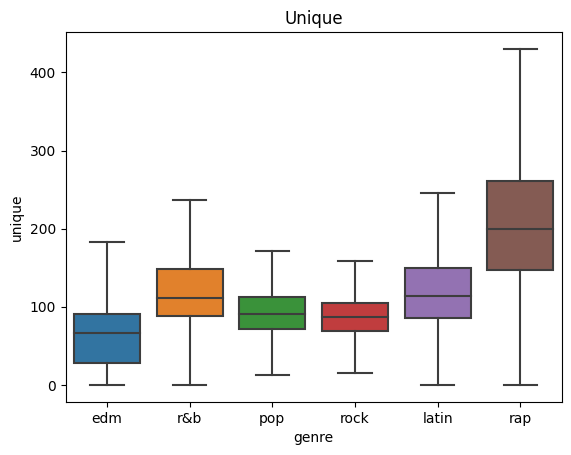

In [ ]:
# visualize unique
make_unique(X_train)
sns.boxplot(data=X_train, x='genre', y='unique', showfliers=False)
plt.title('Unique')

In [ ]:
# extract unique ratio
def make_unique_ratio(df):
  def unique_to_total_ratio(text):
      text_lower = text.lower()

      words = re.findall(r'\b\w+\b', text_lower)
      total_words = len(words)
      num_unique_words = len(set(words))

      if total_words == 0:
          return 0.0
      else:
          ratio = num_unique_words / total_words
          return ratio
  df['ratio'] = df['lyrics'].apply(unique_to_total_ratio)

Text(0.5, 1.0, 'Ratio')

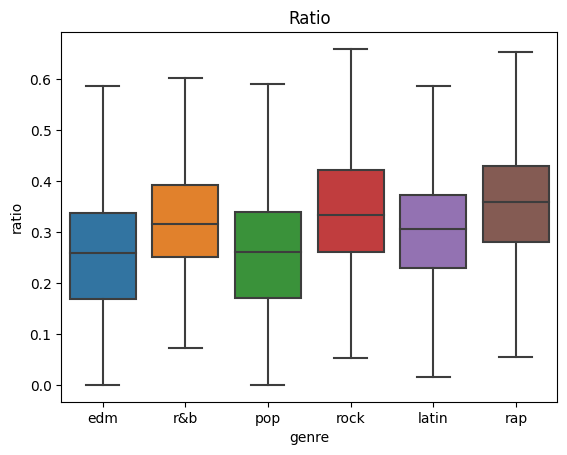

In [ ]:
# visualize unique ratio
make_unique_ratio(X_train)
sns.boxplot(data=X_train, x='genre', y='ratio', showfliers=False)
plt.title('Ratio')

In [ ]:
# extract profanity
def make_profanity_count(df):
  profanity_list = ['fuck', 'bitch', 'shit', 'pussy']
  profanity_count = np.zeros(len(df))
  for word in profanity_list:
    profanity_count += df['lyrics'].str.count(word)
  df['profanity_count'] = profanity_count

Text(0.5, 1.0, 'Profanity')

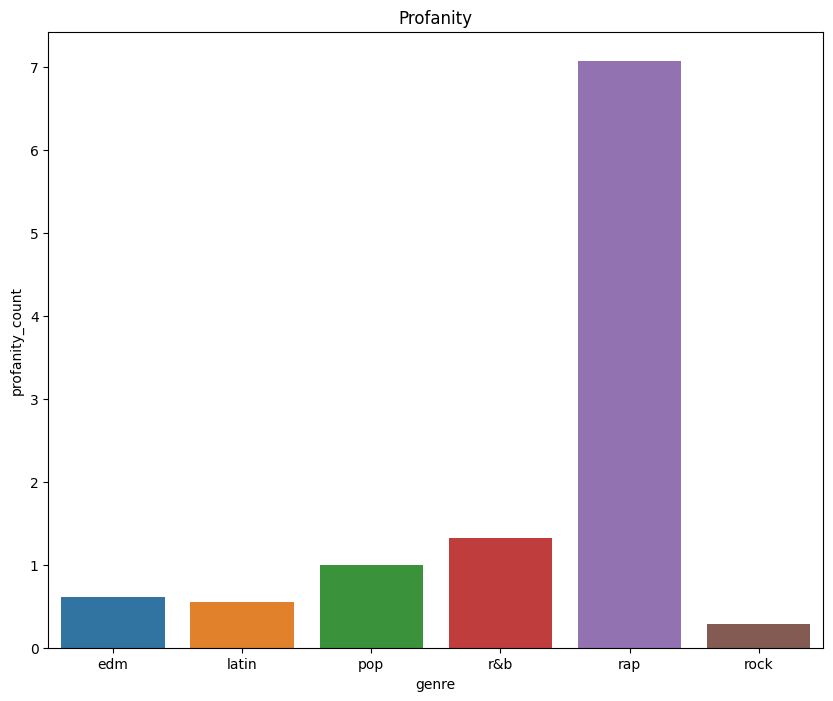

In [ ]:
# visualize profanity
make_profanity_count(X_train)
plt.figure(figsize=(10, 8))
average_count = X_train.groupby('genre')['profanity_count'].mean()
sns.barplot(x=average_count.index, y=average_count)
plt.title('Profanity')

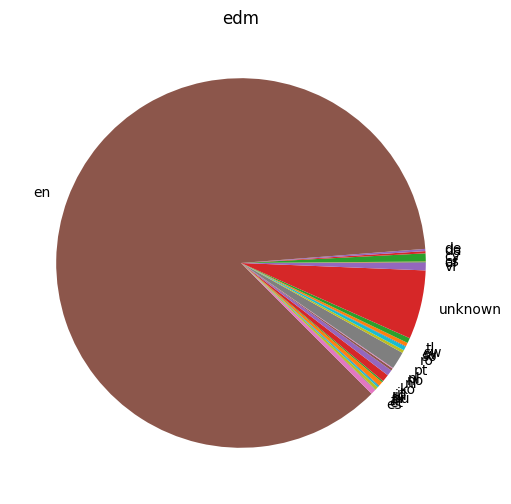

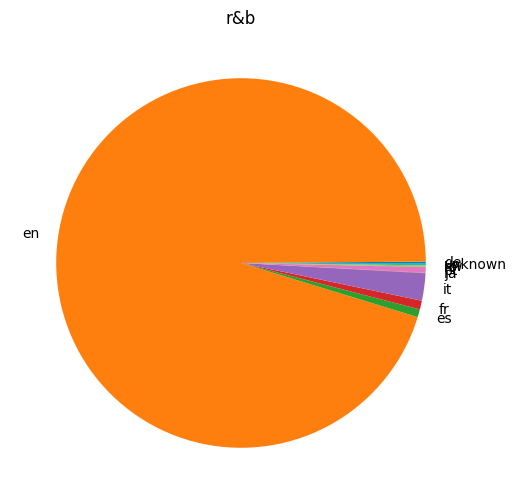

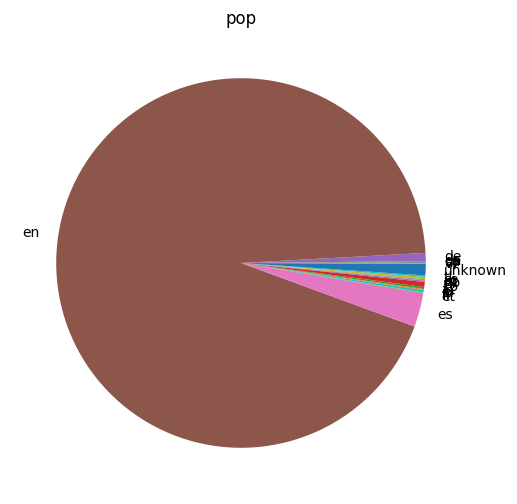

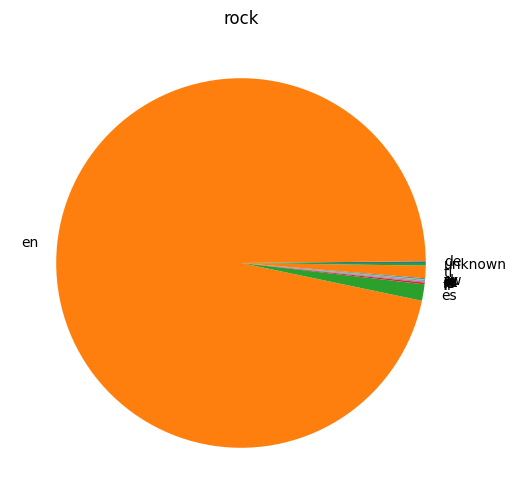

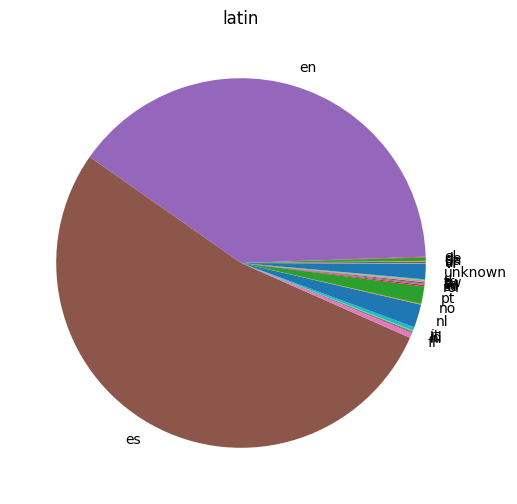

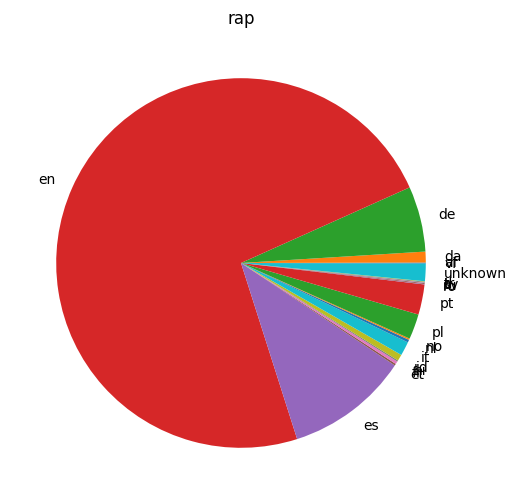

In [ ]:
# visualize language
for genre in X_train['genre'].unique():
  subset = X_train[X_train['genre'] == genre]
  language_counts = subset.groupby('language').size()
  plt.figure(figsize=(8, 6))
  plt.pie(language_counts, labels=language_counts.index)
  plt.title(genre)

In [ ]:
# extract language
def onehot_language(df):
  result_df = pd.get_dummies(df, columns=['language'])
  return result_df

<font size = 6> Data Pipeline

In [ ]:
#create features
def create_features(X):

    #USE ALL FUNCTIONS THAT MAKE FEATURES
    make_profanity_count(X)
    make_word_counts(X, ['baby'])
    make_unique(X)
    X = onehot_language(X)


    #SELECT ONLY FEATURES WE WANT TO USE
    new_X = X[['profanity_count', 'baby', 'unique', 'danceability', 'speechiness', 'energy', 'acousticness', 'tempo', 'language_es']]

    return new_X


X_train_features = create_features(X_train)
X_test_features = create_features(X_test)

In [ ]:
# show
X_train_features

,profanity_count,baby,unique,danceability,speechiness,energy,acousticness,tempo,language_es
16368,0.0,0,3,0.403,0.2670,0.951,0.02420,127.478,0
14054,6.0,0,180,0.593,0.9180,0.751,0.70700,114.907,0
2734,0.0,0,91,0.540,0.0269,0.489,0.41600,130.984,0
17215,0.0,0,88,0.818,0.0476,0.574,0.29000,120.027,0
15043,0.0,0,59,0.634,0.0310,0.630,0.44700,118.628,0
...,...,...,...,...,...,...,...,...,...
11284,0.0,0,99,0.547,0.1010,0.662,0.04170,93.904,0
11964,0.0,2,137,0.700,0.0444,0.630,0.19500,131.950,0
5390,0.0,0,57,0.742,0.0309,0.422,0.55900,134.624,0
860,3.0,0,106,0.576,0.0275,0.750,0.00665,95.018,0


<font size = 6> Model Training

Neural Network

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(16,), (32,), (64,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'max_iter': [100, 200, 300]
}

model = MLPClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(16,), (32,), (64,)],
                         'max_iter': [100, 200, 300],
                         'solver': ['adam', 'sgd']},
             verbose=2)

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters found:  {'activation': 'tanh', 'hidden_layer_sizes': (64,), 'max_iter': 300, 'solver': 'adam'}
Best score:  0.5578811894601369


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_features)

# Creating the neural network model
model = MLPClassifier(hidden_layer_sizes=(64,), activation='tanh', solver='adam', max_iter=300)

# Training the model
model.fit(X_train_norm, y_train)

y_pred = model.predict(X_train_norm)

# Print classification report
print(classification_report(y_train, y_pred))
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

              precision    recall  f1-score   support

         edm       0.64      0.54      0.58      1559
       latin       0.78      0.50      0.61      1629
         pop       0.43      0.43      0.43      2989
         r&b       0.52      0.56      0.54      2474
         rap       0.71      0.76      0.73      2534
        rock       0.58      0.69      0.63      2655

    accuracy                           0.58     13840
   macro avg       0.61      0.58      0.59     13840
weighted avg       0.59      0.58      0.58     13840

Accuracy: 0.5844


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_train_features, y_train, cv=kfold)
print("Cross-validation Accuracy: ", cv_results.mean())

Cross-validation Accuracy:  0.5166907514450867


Random Forest

In [ ]:
# grid search

rf_test = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator=rf_test, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_features, y_train_encoded)
best_params = grid_search.best_params_

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


KeyboardInterrupt: ignored

In [ ]:
# hyperparameters
print(best_params)

In [ ]:
# train model with cross validation
rf = RandomForestClassifier()
rf.fit(X_train_features, y_train)

y_pred = rf.predict(X_train_features)
accuracy = accuracy_score(y_train, y_pred)
scores = cross_val_score(rf, X_train_features, y_train, cv=5)
mean_accuracy = scores.mean()
std_accuracy = scores.std()

In [ ]:
# accuracy
print('Model Accuracy: ' + str(accuracy))
print('Average CV Accuracy: ' + str(mean_accuracy))
print('Standard Deviation: ' + str(std_accuracy))

Model Accuracy: 0.9903179190751445
Average CV Accuracy: 0.39075144508670523
Standard Deviation: 0.005424371207839145


<font size = 6> Model Evaluation

Test Set

In [ ]:
X_test_norm = scaler.transform(X_test_features)
y_pred = model.predict(X_test_norm)

# Print classification report

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5678


Random Model for Comparison

0.16668417630057802


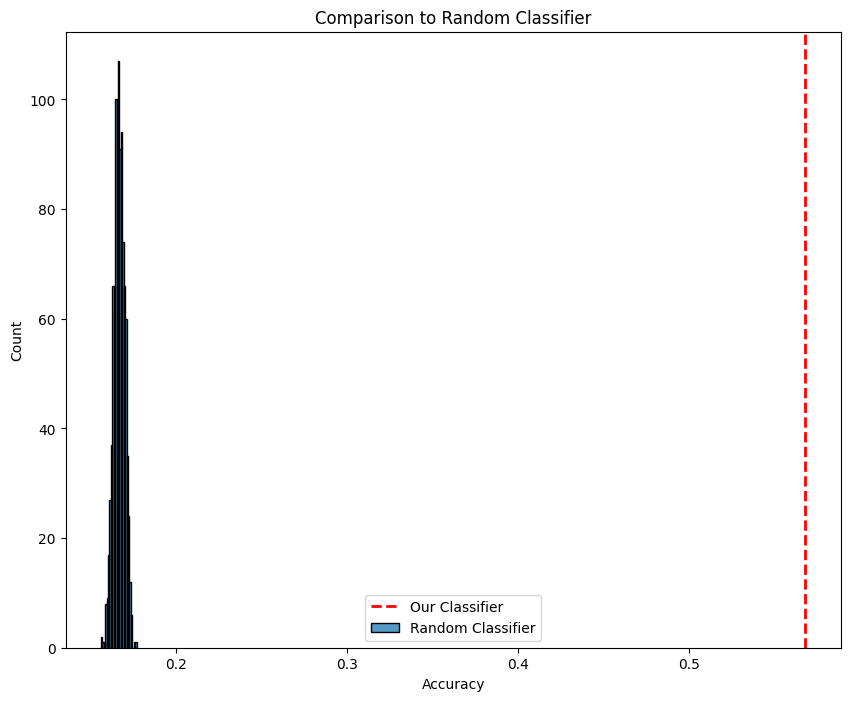

In [ ]:
# run random classification 10000 times, compare to our classifier
labels = y_train.unique()
accuracies = np.array([])
for i in np.arange(1000):
  output = np.random.choice(labels, len(y_train))
  accuracy = np.sum(output == y_train) / len(y_train)
  accuracies = np.append(accuracies, accuracy)
print(np.mean(accuracies))

plt.figure(figsize=(10, 8))
sns.histplot(accuracies, label='Random Classifier')
plt.axvline(x=test_accuracy, color='red', linestyle='--', linewidth=2, label='Our Classifier')
plt.title('Comparison to Random Classifier')
plt.xlabel('Accuracy')
plt.legend()